## Train the model with small train set
All functions, like **get_bow_representation()** and **get_vocabulary()**, offer the possibility to store the result into a file by passing the parameter **'save=True'**

In [4]:
import build_vocabulary as bv
import features_extraction as fe
import train_classifier as tc

iterations = []
types = []
test_accuracy = []
train_accuracy = []


for iter in range(250, 5000, 250):
    voc = bv.get_vocabulary(path='../data/train/', numWords=iter)
    train_data = fe.get_bow_representation(voc, path='../data/train')
    w, b = tc.train_classifier(train_data)

    logits, predictions, accuracy_train = tc.inference_classifier(
        train_data, w, b)

    iterations.append(iter)
    types.append('classic model')
    train_accuracy.append(accuracy_train)

    test_data = fe.get_bow_representation(voc, path='../data/test')
    logits, predictions, accuracy_test = tc.inference_classifier(
        test_data, w, b)
    test_accuracy.append(accuracy_test)

## The model ignores very common words

In [5]:
words_to_ignore = []
f = open('../data/stopwords.txt', 'r')
n = 0
for w in f.read().split():
    words_to_ignore.append(w)
    n += 1
f.close()
for iter in range(250, 5000, 250):
    voc = bv.get_vocabulary(path='../data/train/', numWords=iter)
    voc_no_common_words = [word for word in voc if word not in words_to_ignore]

    train_data = fe.get_bow_representation(voc_no_common_words)
    w, b = tc.train_classifier(train_data)

    logits, predictions, accuracy_train = tc.inference_classifier(
        train_data, w, b)

    iterations.append(iter)
    types.append('Model without common words')
    train_accuracy.append(accuracy_train)

    test_data = fe.get_bow_representation(
        voc_no_common_words, path='../data/test')
    logits, predictions, accuracy_test = tc.inference_classifier(
        test_data, w, b)
    test_accuracy.append(accuracy_test)

## Model with stemming

In [6]:
for iter in range(250, 5000, 250):
    voc = bv.get_vocabulary(path='../data/train/', numWords=iter)

    voc_stem = fe.stem_words(voc)
    train_data = fe.get_bow_representation(voc_stem, stemming=True)
    w, b = tc.train_classifier(train_data)

    logits, predictions, accuracy_train = tc.inference_classifier(
        train_data, w, b)

    iterations.append(iter)
    types.append('Model with stemming')
    train_accuracy.append(accuracy_train)

    test_data = fe.get_bow_representation(
        voc_stem, path='../data/test', stemming=True)
    logits, predictions, accuracy_test = tc.inference_classifier(
        test_data, w, b)
    test_accuracy.append(accuracy_test)

## Model with stemming and ignore common words

In [7]:
for iter in range(250, 5000, 250):
    voc = bv.get_vocabulary(path='../data/train/', numWords=iter)
    voc_no_common_words = [word for word in voc if word not in words_to_ignore]

    voc_stem_no_cwords = fe.stem_words(voc_no_common_words)

    train_data = fe.get_bow_representation(voc_stem_no_cwords, stemming=True)
    w, b = tc.train_classifier(train_data)

    logits, predictions, accuracy_train = tc.inference_classifier(
        train_data, w, b)

    iterations.append(iter)
    types.append('Model with stemming and without common words')
    train_accuracy.append(accuracy_train)

    test_data = fe.get_bow_representation(
        voc_stem_no_cwords, path='../data/test', stemming=True)
    logits, predictions, accuracy_test = tc.inference_classifier(
        test_data, w, b)
    test_accuracy.append(accuracy_test)

## 1.4 Compare different models

<Axes: title={'center': 'Difference between test and train accuracy for different models'}, xlabel='iterations', ylabel='difference'>

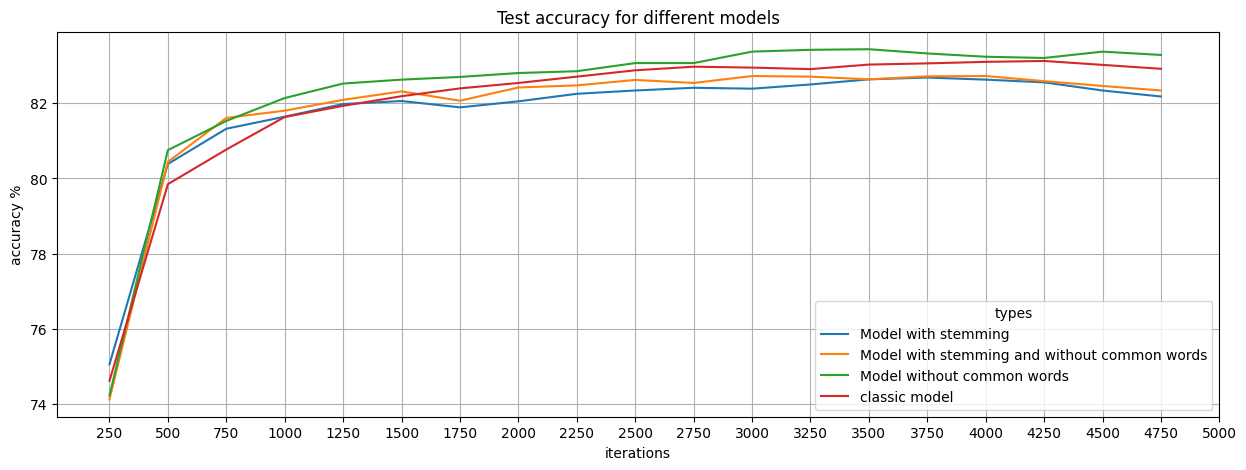

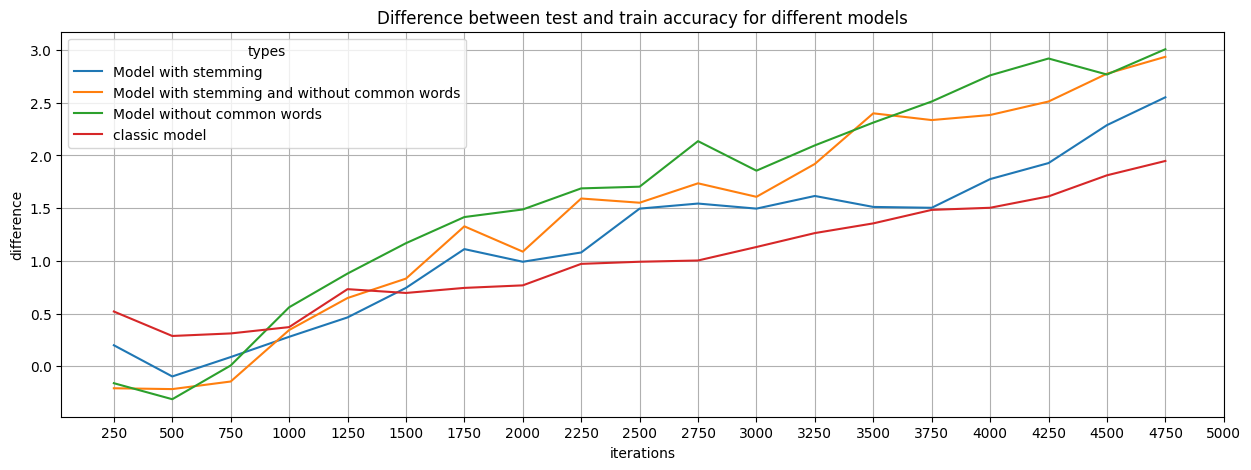

In [9]:
import pandas as pd
results = pd.DataFrame({'iterations': iterations, 'types': types,
                       'test_accuracy': test_accuracy, 'train_accuracy': train_accuracy})

results.to_csv('results.csv', index=True)
results1 = results.pivot(
    index='iterations', columns='types', values='test_accuracy')


results1.plot(kind='line', title='Test accuracy for different models',
              legend=True, grid=True, figsize=(15, 5), xticks=range(250, 5250, 250), ylabel='accuracy %')

results['difference'] = results['train_accuracy']-results['test_accuracy']

results2 = results.pivot(
    index='iterations', columns='types', values='difference')
results2.plot(kind='line', title='Difference between test and train accuracy for different models',
              legend=True, grid=True, figsize=(15, 5), xticks=range(250, 5250, 250), ylabel='difference')

## 1.5 Analysis
Identify the set of most impactful words on the predictions made by the model.  
Also identify the worst errors on the test set, that is, those that the model classifies
with the highest confidence.  
The analysis are made using the model without common words, because it has the highest accuracy

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
words_to_ignore = []
f = open('../data/stopwords.txt', 'r')
n = 0
for w in f.read().split():
    words_to_ignore.append(w)
    n += 1
f.close()

voc = bv.get_vocabulary(path='../data/train/', numWords=1000)
voc_no_common_words = [word for word in voc if word not in words_to_ignore]

train_data = fe.get_bow_representation(voc_no_common_words)
w, b = tc.train_classifier(train_data)

test_data = fe.get_bow_representation(
    voc_no_common_words, path='../data/test')
logits, predictions, accuracy_test = tc.inference_classifier(
    test_data, w, b)

Y = test_data[:, -1]



Text(0, 0.5, 'weights')

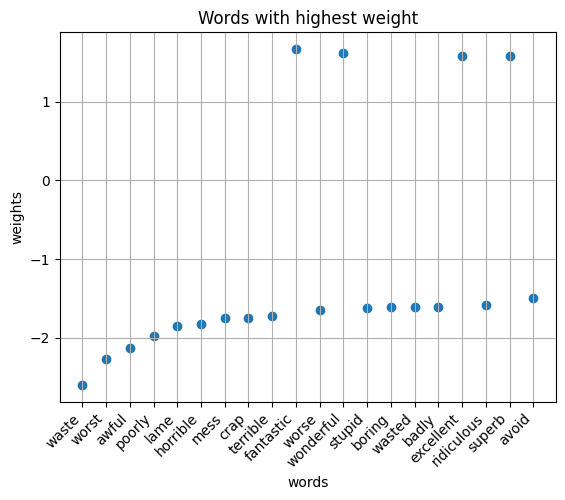

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
words_weights=pd.DataFrame({'words':voc_no_common_words,'weights abs':abs(w),'weights':w})
words_weights.sort_values(by='weights abs',ascending=False,inplace=True)
words_weights=words_weights.head(20)

plt.scatter(x=words_weights['words'],y=words_weights['weights'])
plt.grid()
plt.xticks(rotation=45, ha='right')
plt.title('Words with highest weight')
plt.xlabel('words')
plt.ylabel('weights')

<Axes: title={'center': 'Misclassified logits'}, xlabel='misclassified samples', ylabel='logits'>

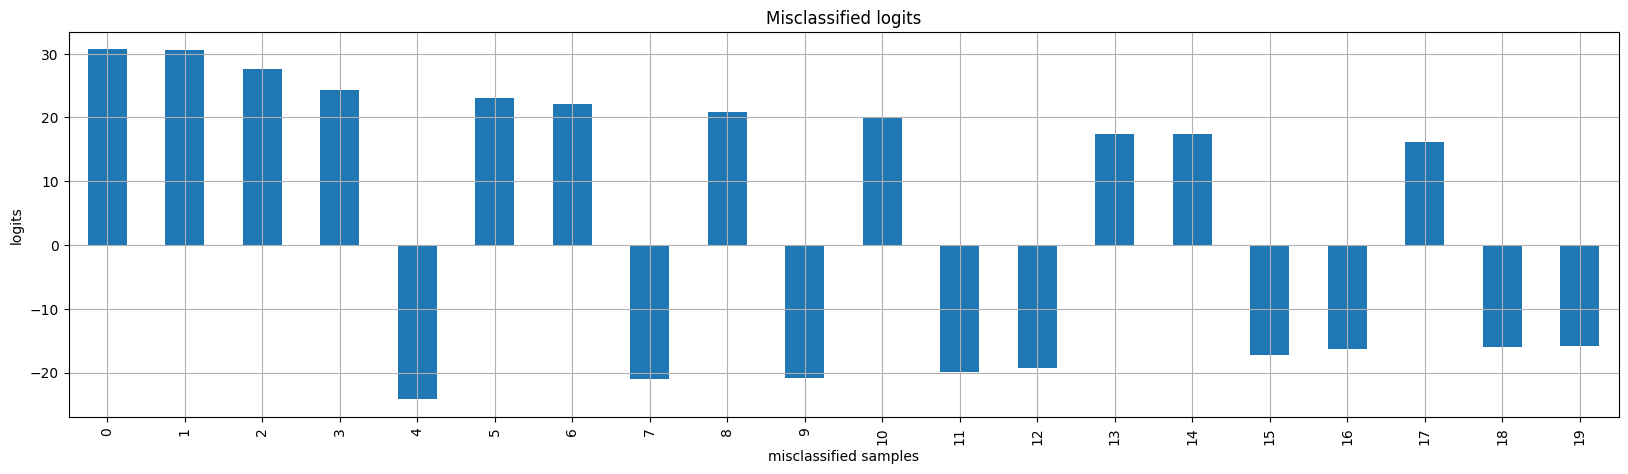

In [ ]:
logits_misclassified=logits[predictions!=Y]
misclassified=pd.DataFrame({'logits':logits_misclassified,'logits abs':abs(logits_misclassified)})
misclassified.sort_values(by='logits abs',ascending=False,inplace=True)
misclassified=misclassified.drop('logits abs',axis=1)
misclassified=misclassified.head(20)
misclassified.plot(kind='bar',title='Misclassified logits',legend=False,grid=True,figsize=(20,5),xticks=range(0,20,1),ylabel='logits',xlabel='misclassified samples')